### Housekeeping

In [1]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sqlite3

In [3]:
# Show all the columns in data frame
pd.set_option('display.max_rows', 500, 'display.max_columns', 500)

In [4]:
# Styling for sns
sns.set_style("white")

### Analyzing the data from retail stores perspective

In [5]:
# Connect to SQLite database
conn = sqlite3.connect('IowaLiquorSales.db')
cursor = conn.cursor()

In [6]:
# Load the store table for analysis
query = '''SELECT * FROM Store;'''
cursor.execute(query)
result = cursor.fetchall()
cursor.close()
conn.close()

In [7]:
# Import the result set into a dataframe
store = pd.DataFrame(result, columns = ['StoreID',
                                        'StoreName',
                                        'City',
                                        'ZipCode',
                                        'CountyNumber',
                                        'County',
                                        'Long',
                                        'Lat'])
store.head(1)

,StoreID,StoreName,City,ZipCode,CountyNumber,County,Long,Lat
0,2663,Hy-vee Food Store,Urbandale,50322,77.0,Polk,-93.74,41.63


In [8]:
# Pull county population data
data = pd.read_csv('data/Iowa_County_Population.csv')
data['Population'] = data['Population'].astype(int)
data.head(1)

,Rank,County,Population
0,1,Polk,479612


In [9]:
store = store.merge(data[['County', 'Population']], on = 'County', how = 'left')

In [10]:
store.head(1)

,StoreID,StoreName,City,ZipCode,CountyNumber,County,Long,Lat,Population
0,2663,Hy-vee Food Store,Urbandale,50322,77.0,Polk,-93.74,41.63,479612.0


### Distribution by County

Text(0.5, 1.0, 'Total stores by county')

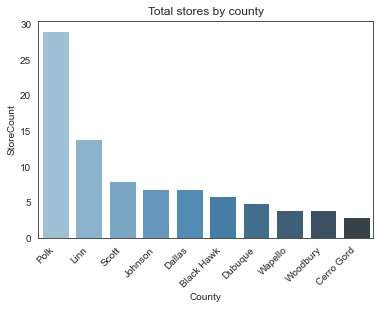

In [11]:
# HyVee store distribution by county
df = store.groupby('County').agg({'StoreID':'count'}).sort_values(by = 'StoreID', ascending = False).head(10).reset_index().rename(columns={'StoreID':'StoreCount'})
ax = sns.barplot(x='County', y='StoreCount', data=df, palette="Blues_d")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_title('Total stores by county', fontsize=12)

Text(0.5, 1.0, 'Store per capita')

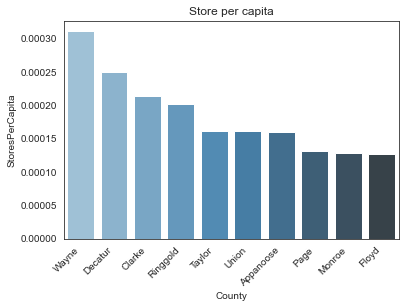

In [12]:
# Store per capita for Hy-Vee
df = store.groupby(['County']).agg({'Population':'first', 'StoreName':'count'}).reset_index().rename(columns={'StoreName':'StoreCount'})
df['StoresPerCapita'] = df['StoreCount'] / df['Population']
df = df.sort_values(by = 'StoresPerCapita', ascending = False).head(10)

ax = sns.barplot(x='County', y='StoresPerCapita', data=df, palette="Blues_d")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_title('Store per capita', fontsize=12)

Text(0.5, 1.0, 'Stores vs County Population')

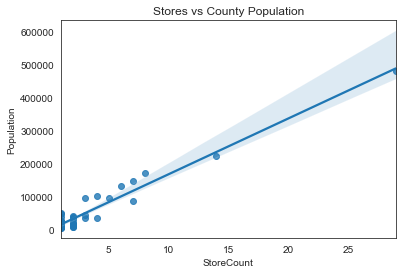

In [13]:
# Determine how the no. of stores vary with respect to population
df = store.groupby(['County']).agg({'Population':'first', 'StoreName':'count'}).reset_index().rename(columns={'StoreName':'StoreCount'})
df['StoresPerCapita'] = df['StoreCount'] / df['Population']

ax = sns.regplot(data = df, x = 'StoreCount', y = 'Population')
ax.set_title('Stores vs County Population', fontsize=12)

### Analyzing the operational lifetime of stores

In [14]:
conn = sqlite3.connect('IowaLiquorSales.db')
cursor = conn.cursor()

query = '''
SELECT
    Store.StoreName,
    Date,
    Store.County,
    Volume,
    Sale
FROM Transactions
LEFT JOIN Store ON Transactions.StoreID = Store.StoreID
WHERE Store.StoreName LIKE '%Hy-vee%';
'''
df = pd.read_sql_query(query, conn)
cursor.close()
conn.close()

In [15]:
df.head(1)

,StoreName,Date,County,Volume,Sale
0,Hy-vee Food Store,2019-07-09 00:00:00,Polk,2.77,90.0


In [16]:
df['Date'] = pd.to_datetime(df['Date'])

Text(0.5, 1.0, 'Avg operational lifetime of stores')

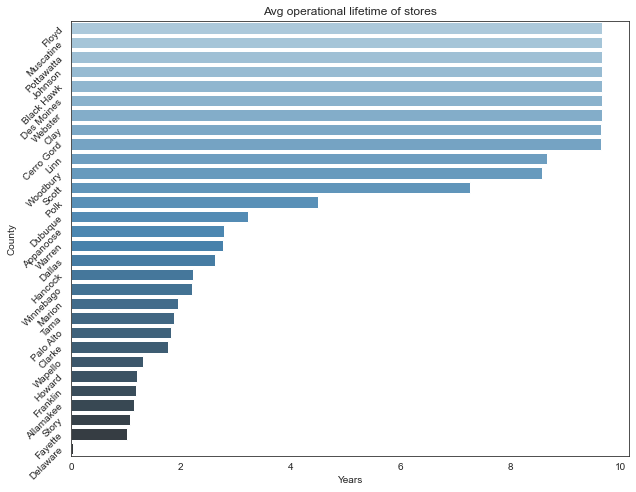

In [17]:
# Store operational lifetime by county
temp = df.groupby(['StoreName']).agg({'Date': lambda x:(x.max() - x.min()).days / 365, 'County': 'first'}).reset_index().rename(columns = {'Date': 'Years', 'County': 'County'})
temp = temp.groupby(['County']).agg({'Years':'mean'}).sort_values(by = 'Years', ascending = False).reset_index()

plt.figure(figsize=(10,8))
ax = sns.barplot(x='Years', y='County', data=temp, palette="Blues_d")
ax.set_yticklabels(ax.get_yticklabels(), rotation=45, horizontalalignment='right')
ax.set_title('Avg operational lifetime of stores', fontsize=12)

In [18]:
df.loc[df['Date'].dt.year == 2021]['StoreName'].nunique()

62

Text(0.5, 1.0, 'Store count over time')

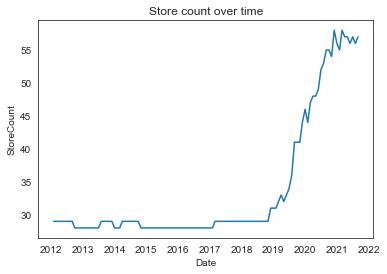

In [19]:
temp = df.groupby([pd.Grouper(key = 'Date',freq = 'M')]).agg({'StoreName':'nunique','Volume':'sum','Sale':'sum'}).reset_index().rename(columns={'StoreName':'StoreCount'})
ax = sns.lineplot(data = temp, x='Date', y='StoreCount')
ax.set_title('Store count over time', fontsize=12)

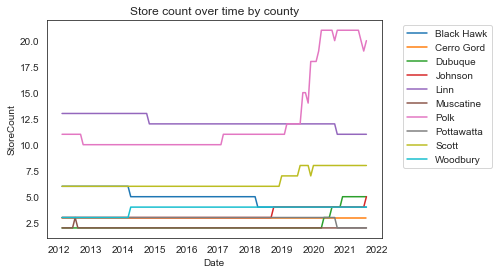

In [20]:
temp = df.groupby(['County',pd.Grouper(key = 'Date',freq = 'M')]).agg({'StoreName':'nunique','Volume':'sum','Sale':'sum'}).reset_index().rename(columns={'StoreName':'StoreCount'})
counties = list(temp.groupby('County').agg({'Volume':'sum'}).reset_index().sort_values(by='Volume', ascending=False)['County'].head(10))

ax = sns.lineplot(data = temp[temp['County'].isin(counties)], x = 'Date', y = 'StoreCount', hue = 'County')
ax.set_title('Store count over time by county', fontsize=12)
plt.legend(bbox_to_anchor = (1.05, 1))

In [21]:
# Import the Sales table
conn = sqlite3.connect('IowaLiquorSales.db')
sales = pd.read_sql_query(
        "SELECT * FROM Sales", conn)
sales['Date'] = pd.to_datetime(sales['Date'], format='%Y/%m/%d')

In [22]:
# Convert county name to upper case
sales['County'] = sales['County'].str.upper()

In [23]:
# Categorize the liquor stores into types
sales['StoreType'] = 'General Store'
sales.loc[sales.StoreName.str.contains('Food Store'), 'StoreType'] = 'Food Store'
sales.loc[sales.StoreName.str.contains('Wine & Spirits'), 'StoreType'] = 'Wine & Spirits'
sales.loc[sales.StoreName.str.contains('Food & Drug'), 'StoreType'] = 'Food & Drugstore'
sales.loc[sales.StoreName=='Drugstore', 'StoreType'] = 'Drugstore'

In [24]:
sales['Year'] = sales['Date'].dt.year
sales['Month'] = sales['Date'].dt.month
sales['Day'] = sales['Date'].dt.day

In [25]:
sales.head(1)

,ProductID,ProductName,Date,Sale,BottlesSold,StoreID,StoreName,CategoryName,BottleVolume,VendorID,VendorName,County,Age,Proof,Long,Lat,StoreType,Year,Month,Day
0,15628,Jameson,2020-07-01,97.44,2,2643,Hy-Vee Wine and Spirits / Waterloo,Irish Whiskies,1750,370.0,PERNOD RICARD USA,BLACK HAWK,0.0,80.0,NaN,NaN,General Store,2020,7,1


Text(0.5, 1.0, 'Total stores over time by store type')

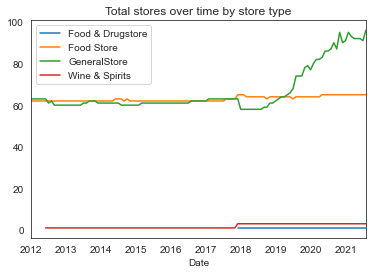

In [26]:
# Total stores over time by type
temp = sales.groupby(['StoreType', 'StoreID', pd.Grouper(key='Date', freq='M')]).agg({'Sale':['sum']})
temp = temp.reset_index('Date').pivot_table(index='Date', columns='StoreType', aggfunc='count')
temp.columns = ['Food & Drugstore', 'Food Store', 'GeneralStore', 'Wine & Spirits']

ax = temp.plot()
ax.set_title('Total stores over time by store type', fontsize=12)

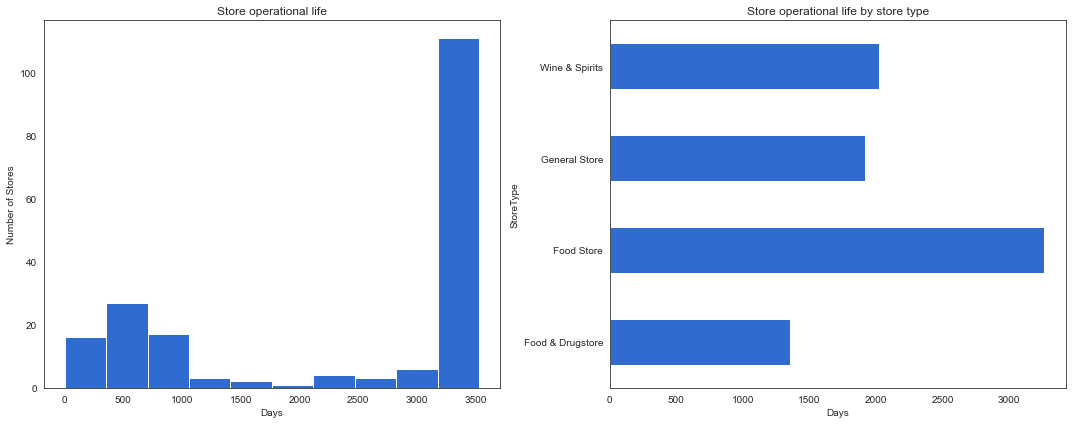

In [27]:
# Create the grid
fig, (axes1, axes2) = plt.subplots(1, 2, figsize=(15, 6), sharey=False)

# Mean operational store life
temp = sales.groupby(['StoreID']).agg( FirstDate = ('Date',min), LastDate = ('Date',max))
temp['Duration'] = temp['LastDate'] - temp['FirstDate']
temp['Duration'].dt.days.plot(kind='hist', ax = axes1, color="#306ccf")
axes1.set_xlabel('Days')
axes1.set_ylabel('Number of Stores')
axes1.set_title('Store operational life', fontsize=12)
fig.tight_layout()

# Mean operational store life by type
temp = sales.groupby(['StoreType','StoreID']).agg(FirstDate = ('Date',min),LastDate = ('Date',max))
temp['Duration'] = temp['LastDate'] - temp['FirstDate']
temp['Duration'] = temp['Duration'].dt.days
temp = temp.groupby('StoreType').agg(Duration = ('Duration','mean'))
temp['Duration'].plot(kind='barh', ax = axes2, color="#306ccf")
axes2.set_title('Store operational life by store type', fontsize=12)
axes2.set_xlabel('Days')
fig.tight_layout()

### Sales volume across stores

Text(0.5, 1.0, 'Liquor sales by county')

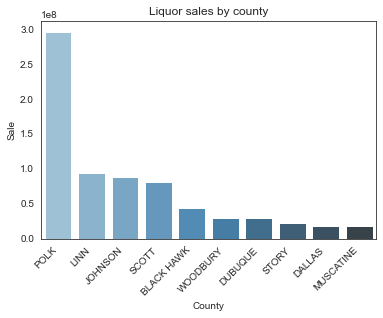

In [28]:
# Liquor sales by county
temp = sales.groupby(['County','Date'])['Sale'].sum().groupby(
            ['County']).sum().sort_values(ascending=False)
temp = pd.DataFrame(temp).reset_index().head(10)
ax = sns.barplot(x='County', y='Sale', data=temp, palette="Blues_d")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_title('Liquor sales by county')

Text(0.5, 0, 'Month Number')

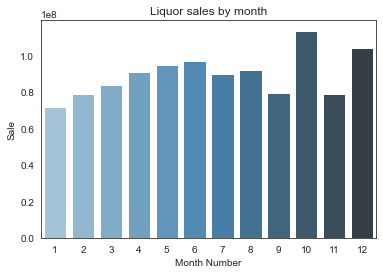

In [29]:
# Liquor sales by month
temp = sales.groupby(['Month'])['Sale'].sum().groupby(
            ['Month']).sum().sort_values(ascending=False)
temp = pd.DataFrame(temp).reset_index().sort_values(by='Month')
ax = sns.barplot(x='Month', y='Sale', data=temp, palette="Blues_d")
ax.set_title('Liquor sales by month')
ax.set_xlabel('Month Number')

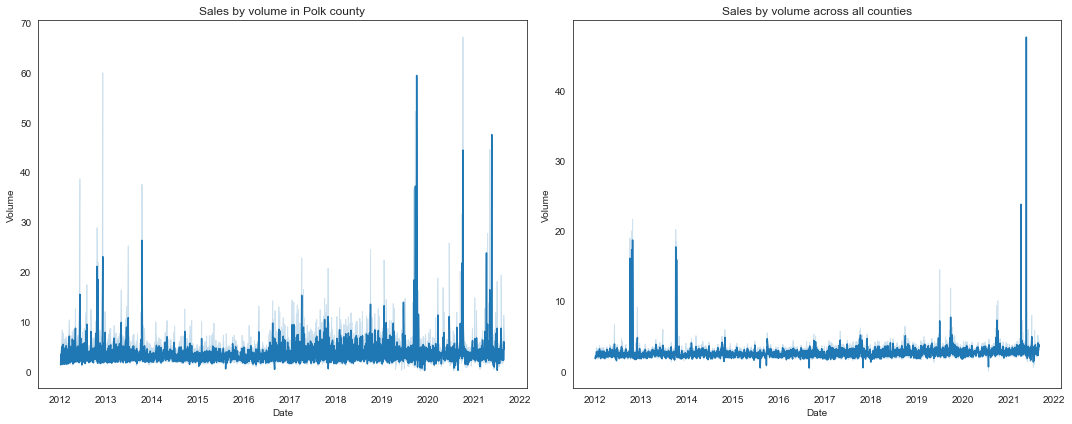

In [30]:
# Create the grid
fig, (axes1, axes2) = plt.subplots(1, 2, figsize=(15, 6), sharey=False)

temp = df[df['County'] == 'Polk']
# Sale in terms of liquor volume sold in Polk county
sns.lineplot(data = temp, x = 'Date', y = 'Volume', ax = axes1)
axes1.set_title('Sales by volume in Polk county')
fig.tight_layout()

# Sale in terms of liquor volume sold across counties
sns.lineplot(data = df, x = 'Date', y = 'Volume', ax = axes2)
axes2.set_title('Sales by volume across all counties')
fig.tight_layout()

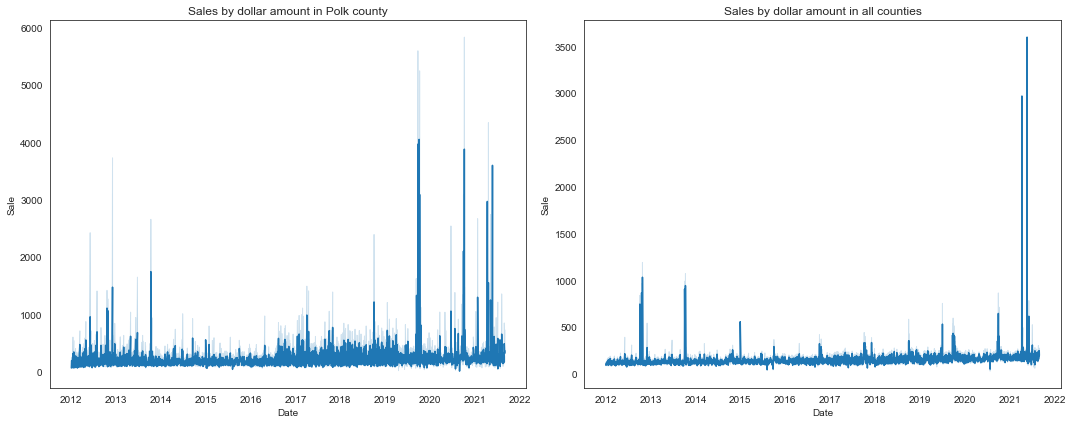

In [31]:
# Create the grid
fig, (axes1, axes2) = plt.subplots(1, 2, figsize=(15, 6), sharey=False)

temp = df[df['County'] == 'Polk']
# Sale in terms of liquor volume sold in Polk county
sns.lineplot(data = temp, x = 'Date', y = 'Sale', ax = axes1)
axes1.set_title('Sales by dollar amount in Polk county')
fig.tight_layout()

# Sale in terms of liquor volume sold across counties
sns.lineplot(data = df, x = 'Date', y = 'Sale', ax = axes2)
axes2.set_title('Sales by dollar amount in all counties')
fig.tight_layout()

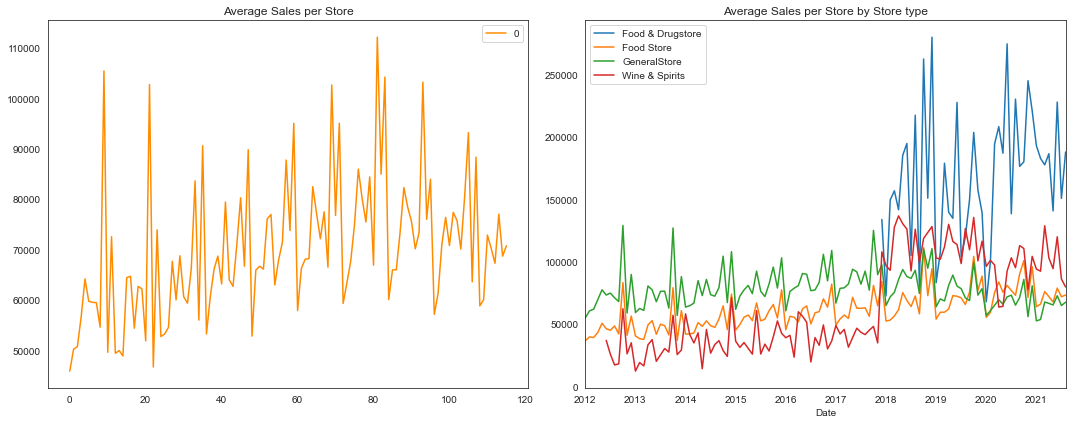

In [32]:
# Create the grid
fig, (axes1, axes2) = plt.subplots(1, 2, figsize=(15, 6), sharey=False)

# Average sales per store
dfstores = sales.groupby(['StoreID', pd.Grouper(key='Date', freq='M')])['Sale'].sum()
dfsales = dfstores.reset_index().groupby('Date').agg(Sale=('Sale','sum')).reset_index()
dfstores = dfstores.reset_index().groupby('Date').agg(Stores=('StoreID', 'count')).reset_index()
avg_sales_per_store = dfsales.Sale/dfstores.Stores
pd.DataFrame(avg_sales_per_store,index=dfstores.index).plot(ax=axes1, color = '#ff8c00')
axes1.set_title('Average Sales per Store')
fig.tight_layout()

# Average sales per store by type
df = sales.groupby(['StoreType','StoreID',pd.Grouper(key='Date', freq='M')]).agg(Sale=('Sale','sum'))
df = df.reset_index().groupby(['StoreType', 'Date']).agg(Sale=('Sale','sum'),Count=('StoreID','count'))

df['avg_sale_per_store'] = df.Sale/df.Count
df = df.pivot_table(index='Date', values='avg_sale_per_store', columns='StoreType')
df.columns = ['Food & Drugstore', 'Food Store', 'GeneralStore', 'Wine & Spirits']

df.plot(ax = axes2)
axes2.set_title('Average Sales per Store by Store type')
fig.tight_layout()

### Distribution of stores

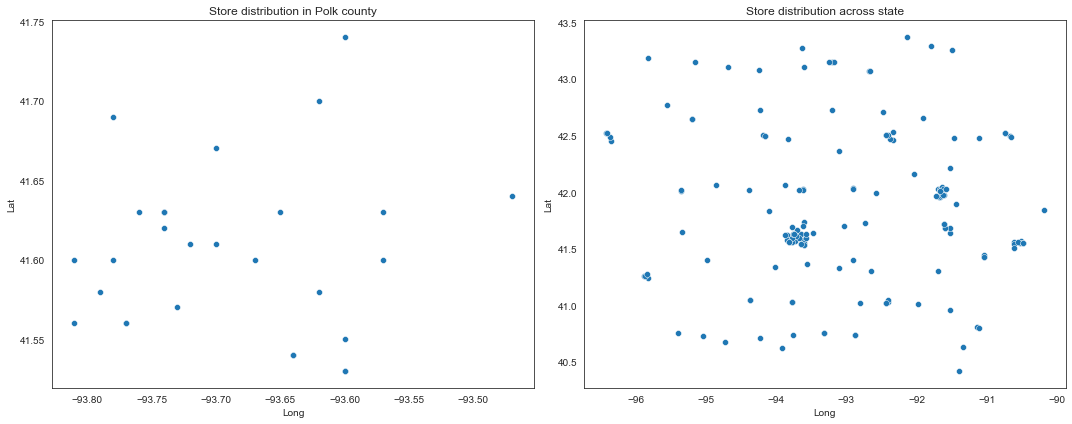

In [33]:
# Create the grid
fig, (axes1, axes2) = plt.subplots(1, 2, figsize=(15, 6), sharey=False)

# Distribution of stores in Polk county
sns.scatterplot(data=store[store['County'] == 'Polk'], x="Long", y="Lat", ax = axes1)
axes1.set_title('Store distribution in Polk county')
fig.tight_layout()

# Distribution of stores across the state
sns.scatterplot(data=store, x="Long", y="Lat", ax = axes2)
axes2.set_title('Store distribution across state')
fig.tight_layout()

### Insights into Hy-Vee's vendors

In [34]:
# Connect to db and load table
conn = sqlite3.connect('IowaLiquorSales.db')
cursor = conn.cursor()
query = '''
SELECT
    Store.StoreName,
    Date,
    VendorID,
    Store.County,
    Volume,
    Sale
FROM Transactions
LEFT JOIN Store ON Transactions.StoreID = Store.StoreID
WHERE Store.StoreName LIKE '%Hy-vee%';
'''
df = pd.read_sql_query(query, conn)
cursor.close()
conn.close()

In [35]:
df.head(1)

,StoreName,Date,VendorID,County,Volume,Sale
0,Hy-vee Food Store,2019-07-09 00:00:00,260.0,Polk,2.77,90.0


In [36]:
# Connect to db and load table
conn = sqlite3.connect('IowaLiquorSales.db')
cursor = conn.cursor()
query = '''
SELECT * FROM Vendor;
'''
vendor = pd.read_sql_query(query, conn)
cursor.close()
conn.close()

Text(0.5, 1.0, 'Top vendors by no of transactions')

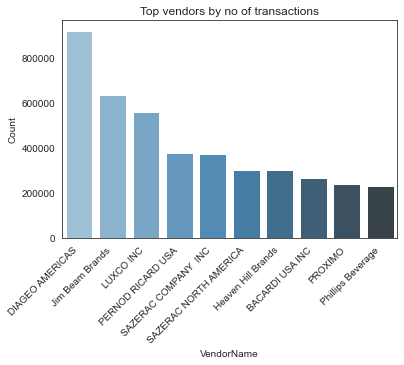

In [37]:
# Looking into the largest vendors by number of transactions
temp = df.merge(vendor[['VendorID', 'VendorName']], on = 'VendorID', how = 'left')
temp = temp.groupby('VendorName').agg({'VendorID':'count'}).sort_values(by = 'VendorID', ascending = False).head(10).reset_index().rename(columns={'VendorID':'Count'})

ax = sns.barplot(x='VendorName', y='Count', data=temp, palette="Blues_d")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_title('Top vendors by no of transactions')

In [38]:
df['Date'] = pd.to_datetime(df['Date'])

Text(0.5, 1.0, 'Txn volume by vendor')

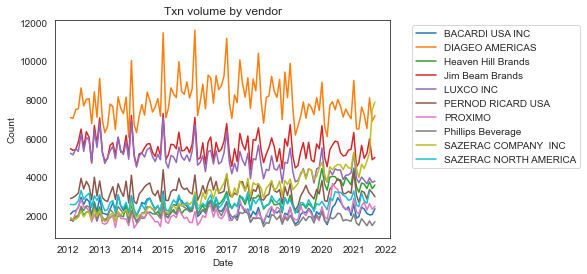

In [39]:
# Transaction volumes of top vendors over the years
temp = df.merge(vendor[['VendorID', 'VendorName']], on = 'VendorID', how = 'left')
temp = temp.groupby(['VendorName',pd.Grouper(key = 'Date',freq = 'M')]).agg({'VendorID':'count'}).reset_index().rename(columns={'VendorID':'Count'})
vendornames = list(temp.groupby('VendorName').agg({'Count':'sum'}).reset_index().sort_values(by='Count', ascending=False)['VendorName'].head(10))

ax = sns.lineplot(data = temp[temp['VendorName'].isin(vendornames)], x = 'Date', y = 'Count', hue = 'VendorName')
plt.legend(bbox_to_anchor = (1.05, 1))
ax.set_title('Txn volume by vendor')

### Product analytics

In [40]:
# Connect to db and load table
conn = sqlite3.connect('IowaLiquorSales.db')
cursor = conn.cursor()
query = '''
SELECT P.ProductID,
    P.ProductName,
    P.Pack,
    P.Segment,
    T.Date,
    T.Sale
FROM Product as P
LEFT JOIN Transactions as T ON P.ProductID = T.ProductID
;
'''
df = pd.read_sql_query(query, conn)
cursor.close()
conn.close()

Text(0.5, 1.0, 'Sale of liquor by segment/category')

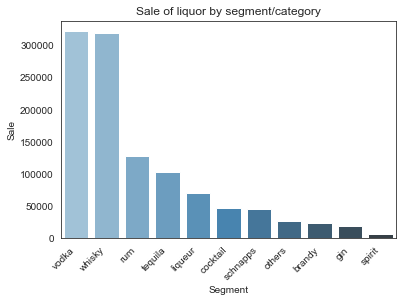

In [41]:
# Sale of liquor by segment/category
temp = df.groupby(['Segment','Pack','Date'])['Sale'].sum().groupby(
            ['Segment','Pack']).max().sort_values().groupby(
            ['Segment']).sum().sort_values(ascending=False)
temp = pd.DataFrame(temp).reset_index()
ax = sns.barplot(x='Segment', y='Sale', data=temp, palette="Blues_d")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_title('Sale of liquor by segment/category')

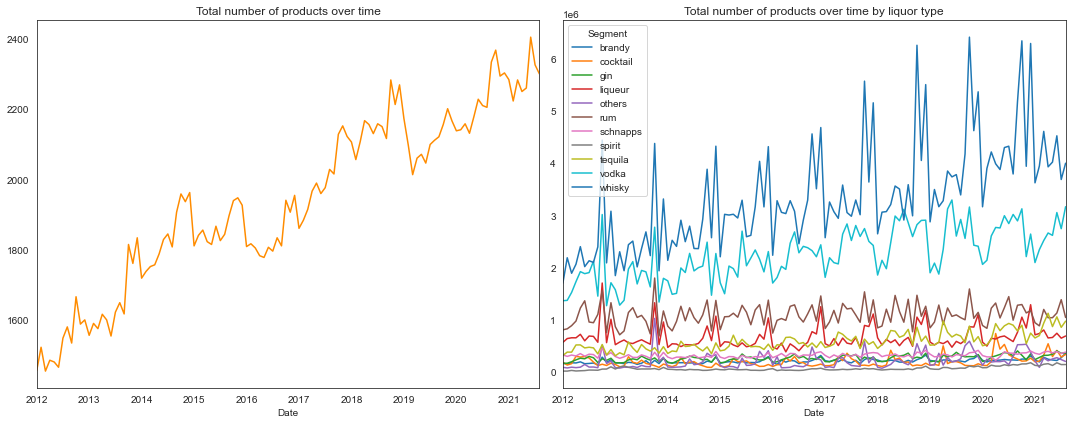

In [42]:
# Create the grid
fig, (axes1, axes2) = plt.subplots(1, 2, figsize=(15, 6), sharey=False)

# Total number of products over time
df = sales.groupby(['ProductID', pd.Grouper(key='Date', freq='M')])['Sale'].sum()
df = df.reset_index('Date').pivot_table(index='ProductID', columns='Date', aggfunc=np.sum)
df.columns = df.columns.droplevel(0)

df.count().plot(ax = axes1, color = '#ff8c00')
axes1.set_title('Total number of products over time')
fig.tight_layout()

# Create a Segments column
sales['Segment'] = np.where(sales['CategoryName'].str.contains('rum', case=False),'rum',
                   np.where(sales['CategoryName'].str.contains('gin', case=False),'gin', 
                   np.where(sales['CategoryName'].str.contains('cocktail', case=False), 'cocktail',
                   np.where(sales['CategoryName'].str.contains('brandy|brandies', case=False), 'brandy',
                   np.where(sales['CategoryName'].str.contains('whisk|bourbon|scotch', case=False), 'whisky',
                   np.where(sales['CategoryName'].str.contains('tequila|mezcal', case=False), 'tequila',
                   np.where(sales['CategoryName'].str.contains('schnapps', case=False), 'schnapps',
                   np.where(sales['CategoryName'].str.contains('vodka', case=False), 'vodka',
                   np.where(sales['CategoryName'].str.contains('spirit', case=False), 'spirit',
                   np.where(sales['CategoryName'].str.contains('liqueur', case=False), 'liqueur','others'))))))))))

# Total no of products over time by product type
df = sales.groupby(['Segment', 'ProductID', pd.Grouper(key='Date', freq='M')]).agg(Sale=('Sale','sum'))
df = df.reset_index('Date').pivot_table(index='Date', values='Sale', columns='Segment', aggfunc=np.sum)
df = df.fillna(0)

df.plot(ax = axes2)
axes2.set_title('Total number of products over time by liquor type')
fig.tight_layout()